In [90]:
#Dependencies
import tweepy   #version tweepy==3.7.0
import csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
from textblob import TextBlob

In [22]:
#Variables that contain some important user credentials. Fetch it from --> https://developer.twitter.com/en/apps/
consumer_key = "es3zRIB8RXovEXPQ2DYM7OFZQ"
consumer_secret = "X2SXzg5YdmxBDUrLRePdM4fSojYBAeLZJ6SrE6NUfnTS25i9Uz"

access_token = "1075256198348193793-s4yAPY349aRvMFHPf2zDFCIBkHtPLZ"
access_token_secret = "BXo67xm6TzXOSKZU3Hpcb6pzCMLIKKwUDVQ3EZknejTGg"

# Streaming the data


In [23]:
#importing the required libraries
from tweepy import API
from tweepy import Cursor

from tweepy.streaming import StreamListener
from tweepy import OAuthHandler
from tweepy import Stream

In [24]:
#Twitter client
class TwitterClient():
    
    def __init__(self, twitter_user=None):#default argument
        self.auth = TwitterAuthenticator().authenticate_twiter_app()
        self.twitter_client = API(self.auth)
        
        self.twitter_user = twitter_user
        
    def get_twitter_client_api(self):
        return self.twitter_client
    
    def get_user_timeline_tweets(self, num_tweets):
        tweets = []
        for tweet in Cursor(self.twitter_client.user_timeline, id=self.twitter_user).items(num_tweets):
            tweets.append(tweet)
        return tweets
    
    def get_friend_list(self, num_friends):
        friend_list = []
        for friend in Cursor(self.twitter_client.friends, id=self.twitter_user).items(num_friends):
            friend_list.append(friend)
        return friend_list
    
    def get_home_timeline_tweets(self, num_tweets):
        home_timeline_tweets = []
        for tweet in Cursor(self.twitter_client.home_timeline, id=self.twitter_user).items(num_tweets):
            home_timeline_tweets.append(tweet)
        return home_timeline_tweets
        

In [25]:
#Twitter Authenticator
class TwitterAuthenticator():
    
    def authenticate_twiter_app(self):
        auth = OAuthHandler(consumer_key, consumer_secret)
        auth.set_access_token(access_token, access_token_secret)
        return auth    

In [26]:
#Twitter Streamer
class TwitterStreamer():
    """
        Class for streaming and processing live tweets
    """
    def __init__(self):
        self.twitter_authenticator = TwitterAuthenticator()
    
    def stream_tweets(self, fetched_tweets_filename, hash_tag_list):
        #This handles Twitter authentication and connection with Streaming APIs.
        listener = StdOutListner(fetched_tweets_filename)
        auth = self.twitter_authenticator.authenticate_twiter_app()
        stream = Stream(auth, listener)
    
        stream.filter(track=hash_tag_list)
        
        

In [27]:
#Standard Output Listener
class StdOutListner(StreamListener):
    """
        This is basic listener class that just prints recieved tweets to stdouts.
    """
    def __init__(self, fetched_tweets_filename):
        self.fetched_tweets_filename = fetched_tweets_filename
    
    #overloaded function that listens to tweets fetched
    def on_data(self,data):
        try:
            print(data)
            with open(self.fetched_tweets_filename, 'a') as tf:
                tf.write(data)
            return True
        except BaseException as e:
            print("Error on data: %s" %str(e))
        return True
    
    #overloaded function that looks for errors
    def on_error(self, status):
        if status == 420:
            #returns false message if rate limit occurs.
            return False
        print(status) 

In [91]:
#Tweet Analyser
class TweetAnalyzer():
    """
    Functionality for analysing and categorising tweets
    """
    
    def clean_tweet(self, tweet):
        return ' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)", " ", tweet).split())

    
    def analyze_sentiment(self, tweet):
        analysis = TextBlob(self.clean_tweet(tweet))
        
        if analysis.sentiment.polarity > 0:
            return 1
        elif analysis.sentiment.polarity == 0:
            return 0
        else:
            return -1
        
    def tweets_to_data_frame(self, tweets):
        df = pd.DataFrame(data=[tweet.text for tweet in tweets], columns=['Tweets'])
        df['id'] = np.array([tweet.id for tweet in tweets])
        df['len'] = np.array([len(tweet.text) for tweet in tweets])
        df['date'] = np.array([tweet.created_at for tweet in tweets])
        df['source'] = np.array([tweet.source for tweet in tweets])
        df['likes'] = np.array([tweet.favorite_count for tweet in tweets])
        df['retweets'] = np.array([tweet.retweet_count for tweet in tweets])

        return df

In [111]:
if __name__ == "__main__":
    
    twitter_client = TwitterClient()
    tweet_analyzer = TweetAnalyzer()

    api = twitter_client.get_twitter_client_api()

    tweets = api.user_timeline(screen_name="NDTVProfit", count=100)

    #print(dir(tweets[0]))
    #print(tweets[0].retweet_count)

    df = tweet_analyzer.tweets_to_data_frame(tweets)
    df['sentiment'] = np.array([tweet_analyzer.analyze_sentiment(tweet) for tweet in df['Tweets']])


In [112]:
#dir(tweets[0])

In [114]:
df.head()

,Tweets,id,len,date,source,likes,retweets,sentiment
0,"Sensex Sheds 689 Points To Close At 35,742, Ni...",1076058498205536256,91,2018-12-21 10:15:12,Twitter Web Client,5,2,0
1,Centre Likely To Renew Demand For Extra Divide...,1076047277595054080,89,2018-12-21 09:30:37,Twitter Web Client,16,6,0
2,State-Owned Bank Officers' Union On Strike Tod...,1076036273054179328,92,2018-12-21 08:46:53,Twitter Web Client,8,2,0
3,Court Dismisses Appeal Against LIC Move To Acq...,1076021041854439424,92,2018-12-21 07:46:22,Twitter Web Client,15,2,0
4,Sensex sinks over 400 points as global selloff...,1075993954519117824,137,2018-12-21 05:58:44,Twitter Web Client,11,2,-1


In [115]:
# Get average length over all tweets:
print("Mean Length: "+str(np.mean(df['len'])))

# Get the number of likes for the most liked tweet:
print("Max Likes: "+str(np.max(df['likes'])))


# Get the number of retweets for the most retweeted tweet:
print("Max Retweets: "+str(np.max(df['retweets'])))
    
#print(df.head(10))


Mean Length: 90.88
Max Likes: 139
Max Retweets: 41


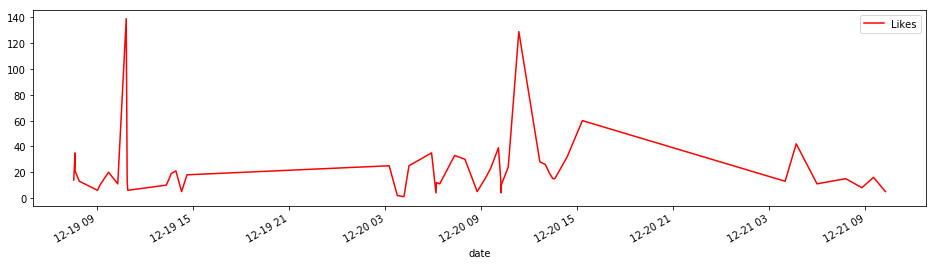

In [116]:
# Time Series
time_likes = pd.Series(data=df['likes'].values, index=df['date'])
time_likes.plot(figsize=(16, 4), color='r', label="Likes", legend=True)

plt.show()

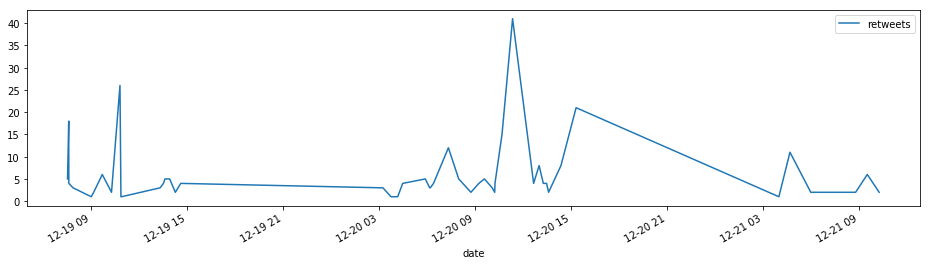

In [117]:
time_retweets = pd.Series(data=df['retweets'].values, index=df['date'])
time_retweets.plot(figsize=(16, 4), label="retweets", legend=True)

plt.show()

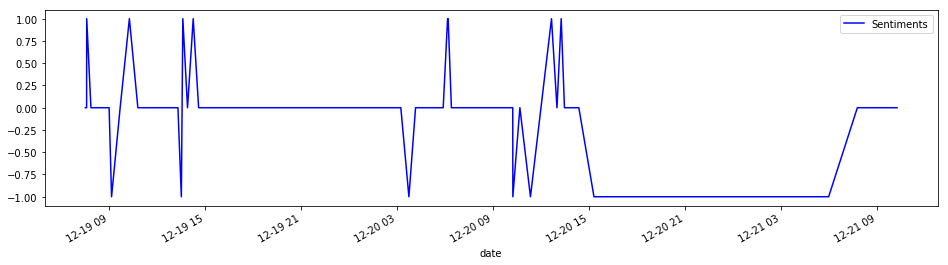

In [118]:
time_sentiment = pd.Series(data=df['sentiment'].values, index=df['date'])
time_sentiment.plot(figsize=(16, 4), color='b', label="Sentiments", legend=True)

plt.show()

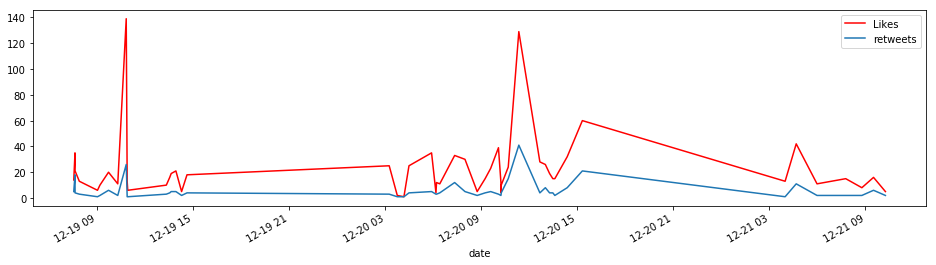

In [119]:
time_likes = pd.Series(data=df['likes'].values, index=df['date'])
time_likes.plot(figsize=(16, 4), color='r', label="Likes", legend=True)
time_retweets = pd.Series(data=df['retweets'].values, index=df['date'])
time_retweets.plot(figsize=(16, 4), label="retweets", legend=True)

plt.show()